## Find indices golden pair indices in output JSON

In [1]:
def gold_idx(data, pairs):
    en_frms = set(map(lambda x: x[0], pairs))
    l2_frms = set(map(lambda x: x[1], pairs))

    en_idx = [
        i
        for i, name in enumerate(data['indices'][0])
        if data['frames'][name]['name'] in en_frms
    ]

    l2_idx = [
        i
        for i, name in enumerate(data['indices'][1])
        if data['frames'][name]['name'] in l2_frms
    ]
    
    return en_idx, l2_idx

## Prepare scoring data and gold to train classifier

In [2]:
import numpy as np
from itertools import product

def clf_data(data, pairs, en_idx, l2_idx):
    alignments = [a for a in data['alignments'] if a['type'] != 'attr_matching'] 

    for alignment in alignments:
        array = np.array(alignment['data'])
        array = array[:, l2_idx]
        alignment['np_array'] = array[en_idx].flatten()

    X = np.stack([a['np_array'] for a in alignments]).T

    y = []

    for f1, f2 in product(en_idx, l2_idx):
        i = data['indices'][0][f1]
        en_frm = data['frames'][i]['name']
        j = data['indices'][1][f2]
        l2_frm = data['frames'][j]['name']

        y.append(1 if (en_frm, l2_frm) in pairs else 0)

    y = np.array(y)
    
    return X, y

## Read all existing alignments and preprocess data

In [5]:
import os
import re
import json

outpath = os.path.join('..', 'out')
names = []
data = []

for filename in os.listdir(outpath):
    dbname = re.search(r'\d+_(\w*)', filename).group(1)
    datapath = os.path.join(outpath, filename)
    goldpath = os.path.join('..', 'data', 'gold', f'{dbname}.txt')
    
    with open(datapath) as fp:
        outdata = json.load(fp)

    with open(goldpath) as fp:
        pairs = set(map(lambda l: tuple(l.split()), fp.readlines()))
        
    en_idx, l2_idx = gold_idx(outdata, pairs)
    
    data.append(clf_data(outdata, pairs, en_idx, l2_idx))
    names.append(dbname)

## Variable density

In [6]:
import numpy as np 
from sklearn.neighbors import KernelDensity

lu_wordnet = data[0][0][:, 1]
frame_def_muse = data[0][0][:, 8]

lu_wordnet = lu_wordnet[lu_wordnet > 0].reshape(-1, 1)
frame_def_muse = frame_def_muse[np.random.randint(len(frame_def_muse), size=10000)].reshape(-1, 1)

In [7]:
kde_wn = KernelDensity(kernel="gaussian", bandwidth=0.01).fit(lu_wordnet)
kde_muse = KernelDensity(kernel="gaussian", bandwidth=0.01).fit(frame_def_muse.reshape(-1, 1))

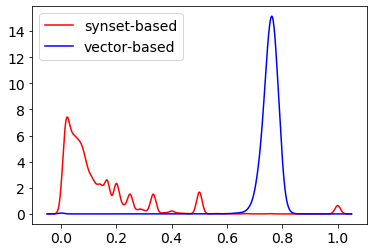

In [16]:
import matplotlib.pyplot as plt

# _, ax = plt.subplots(figsize=(10,10))

X_plot = np.linspace(-0.05, 1.05, 1000)[:, np.newaxis]
plt.plot(X_plot, np.exp(kde_wn.score_samples(X_plot)), 'r', label="synset-based")
plt.plot(X_plot, np.exp(kde_muse.score_samples(X_plot)), 'b', label="vector-based")
plt.legend(loc="upper left", fontsize=14)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)

plt.savefig('chart.png', transparent=True, dpi=300)
plt.show()
plt.close()

## Train SVM to test data and plotting

In [9]:
from sklearn.svm import SVC

X, y = data[0]

svm = SVC(kernel='linear', probability=True)
svm.fit(X, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

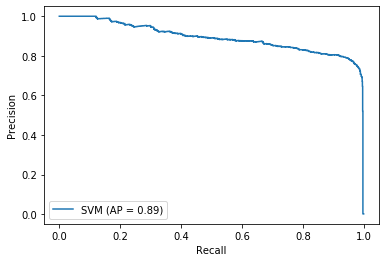

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, PrecisionRecallDisplay, precision_recall_curve

y_pred = svm.predict_proba(X).T[1]
precision, recall, _ = precision_recall_curve(y, y_pred)
average_precision = average_precision_score(y, y_pred)
disp = PrecisionRecallDisplay(precision, recall, average_precision, 'SVM')
disp.plot()
plt.show()

## Train all LogReg classifiers

In [5]:
from sklearn.linear_model import LogisticRegressionCV

clfs = []

for X, y in data:
    logreg = LogisticRegressionCV(cv=4, max_iter=1000, random_state=25)
    logreg.fit(X, y)
    
    clfs.append(logreg)
    
    print('Clf trained!')

Clf trained!
Clf trained!
Clf trained!
Clf trained!
Clf trained!
Clf trained!
Clf trained!
Clf trained!


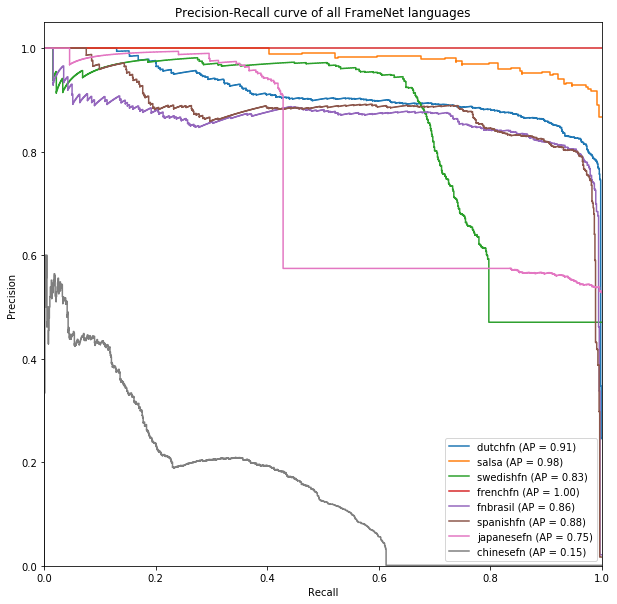

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, PrecisionRecallDisplay, precision_recall_curve

_, ax = plt.subplots(figsize=(10,10))

for name, (X, y), clf in zip(names, data, clfs):
    y_pred = clf.decision_function(X)
    precision, recall, _ = precision_recall_curve(y, y_pred)
    average_precision = average_precision_score(y, y_pred)

    display = PrecisionRecallDisplay(precision, recall, average_precision, 'LogReg')
    display.plot(ax=ax, name=name)
    
handles, labels = display.ax_.get_legend_handles_labels()
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Precision-Recall curve of all FrameNet databases")

plt.show()